### Importing the necessary packages

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import gc
import os
import matplotlib.pyplot as plt

In [83]:
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.metrics.pairwise import pairwise_distances,cosine_distances

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ratings=pd.read_csv('C:/Users/Admin/Downloads/train (2).csv')
print(ratings.shape)
ratings.head()

(132551, 4)


,UserId,productid,Quantity,OrderDate
0,18075,12322648,1,01/04/18
1,6820,12371370,1,01/04/18
2,6820,12973004,1,01/04/18
3,6820,12657560,1,01/04/18
4,6820,11659914,1,01/04/18


# Collaborative filtering based on quantities

### The quantity in the given table is not aggregated for a respective user_id and Product_id. Thus, we make some manipulations to aggregate the quantity column.

In [4]:
sparse_item_user = sparse.csr_matrix((ratings['Quantity'].astype(float), (ratings['productid'], ratings['UserId'])))

In [5]:
sparse_user_item = sparse.csr_matrix((ratings['Quantity'].astype(float), (ratings['UserId'], ratings['productid'])))

In [6]:
value = sparse_user_item.data
column_index = sparse_user_item.indices
row_pointers = sparse_item_user.indices

In [7]:
row_index=np.sort(row_pointers)

In [8]:
column_indexsort=np.sort(column_index)

In [9]:
cs=np.unique(column_indexsort)

In [10]:
rs=np.unique(row_index)

In [11]:
d={'Userid':row_index,'Productid':column_index,'Quantity':value}

In [12]:
df=pd.DataFrame(d)
dfsort=df.sort_values(by=['Productid','Userid'])

In [13]:
sortprod=dfsort.Productid.unique()

### A function which labels the product_id from 0. 

In [14]:
def func(n):
    for i,j in zip(sortprod,range(len(sortprod))):
        if n==i:
            return j

In [15]:
prodlabel=list(map(func,dfsort.Productid))

In [16]:
dfsort["label"]=prodlabel  #label denotes the product_id

### Creating a matrix with user_id as rows and product_id as columns

In [17]:
n_users = dfsort.Userid.unique().shape[0]
n_items = dfsort.Productid.unique().shape[0]

In [18]:
data_matrix = np.zeros((n_users, n_items))

In [19]:
for i in dfsort.itertuples():
    #print(i)
    data_matrix[i[1], i[4]] = i[3]

### Calculating user-user similarity

In [20]:
%%time
user_similarity = pairwise_distances(data_matrix, metric='cosine')

Wall time: 29.5 s


In [21]:
user_similarity_df = pd.DataFrame(user_similarity, index=rs, columns=rs)

In [22]:
%%time
#here 0 denotes high similarity, hence we do this to get the opposite of it
user_similarity_df = 1 - user_similarity_df

Wall time: 20.4 s


In [23]:
del user_similarity
gc.collect()

27

### Calculating item-item similarity

In [24]:
%%time
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

Wall time: 3.12 s


In [25]:
item_similarity_df = pd.DataFrame(item_similarity, index=cs, columns=cs)

In [26]:
#here 0 denotes high similarity, hence we do this to get the opposite of it
item_similarity_df = 1 - item_similarity_df

In [27]:
del item_similarity
gc.collect()

0

### A function which calculates scores to recommend a product to a user. Higher the score, higher is the probability that the user will like the product.

In [28]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [29]:
%%time
item_prediction = predict(data_matrix, item_similarity_df.values, type='item')

Wall time: 3.65 s


In [30]:
item_prediction_df = pd.DataFrame(item_prediction, index=rs, columns=cs)

In [31]:
item_prediction

array([[0.0004499 , 0.0004501 , 0.00045008, ..., 0.00044978, 0.00045008,
        0.00045023],
       [0.00045608, 0.00045628, 0.00045635, ..., 0.00045596, 0.00045626,
        0.00045641],
       [0.00038994, 0.00039012, 0.0003901 , ..., 0.00038984, 0.0003901 ,
        0.00039022],
       ...,
       [0.00040755, 0.00040774, 0.00040771, ..., 0.00040745, 0.00040771,
        0.00040785],
       [0.00239058, 0.00239167, 0.00239154, ..., 0.00238997, 0.00239154,
        0.00239231],
       [0.00132398, 0.00132458, 0.0013261 , ..., 0.00132363, 0.0013245 ,
        0.00132493]])

In [32]:
del item_prediction
gc.collect()

0

In [34]:
%%time
user_prediction = predict(data_matrix, user_similarity_df.values, type='user')

Wall time: 2min 19s


In [35]:
user_prediction_df = pd.DataFrame(user_prediction, index=rs, columns=cs)

In [36]:
test_df = pd.read_csv('C:/Users/Admin/Downloads/test_nFNPSyV.csv')

In [37]:
item_pred_sub = pd.DataFrame(columns=['UserId', 'product_list'])
item_pred_sub['UserId'] = test_df['UserId'].values

In [38]:
sub_list = []
for user in item_pred_sub['UserId'].values:
    sub_list.append(item_prediction_df.loc[user].sort_values(ascending=False)[0:10].index.values.tolist())

In [39]:
item_pred_sub['product_list'] = sub_list

In [40]:
item_pred_sub

,UserId,product_list
0,2,"[11659418, 12936758, 11407244, 12995900, 12406..."
1,28,"[13650254, 13039772, 12407206, 11659818, 12437..."
2,36,"[13650238, 11360718, 12936666, 11150104, 11714..."
3,38,"[11659790, 11659724, 12423464, 11147300, 11407..."
4,41,"[11360904, 13650186, 11659466, 12995900, 11659..."
5,52,"[11407394, 12445160, 11360904, 13650186, 12407..."
6,67,"[11714606, 11659276, 12407210, 12995900, 12407..."
7,69,"[11659150, 13039938, 12436648, 12936748, 11660..."
8,80,"[11407388, 12437468, 11141308, 11147258, 13039..."
9,97,"[12657410, 13039916, 11520046, 11603792, 11660..."


In [41]:
item_pred_sub.to_csv('item_pred_sub.csv', index=False)

In [42]:
from IPython.display import FileLink

In [43]:
FileLink('item_pred_sub.csv')

C:\Users\Admin\Downloads\item_pred_sub.csv

In [44]:
user_pred_sub = pd.DataFrame(columns=['UserId', 'product_list'])
user_pred_sub['UserId'] = test_df['UserId'].values

In [45]:
sub_list = []
for user in user_pred_sub['UserId'].values:
    sub_list.append(user_prediction_df.loc[user].sort_values(ascending=False)[0:10].index.values.tolist())

In [46]:
user_pred_sub['product_list'] = sub_list


In [47]:
user_pred_sub

,UserId,product_list
0,2,"[11660064, 12407154, 12658512, 12371280, 12973..."
1,28,"[12360404, 11659838, 12658512, 13039778, 12407..."
2,36,"[12360448, 12407648, 12658512, 11460916, 12407..."
3,38,"[12406972, 11659712, 11659798, 12658512, 12407..."
4,41,"[11659236, 12658512, 12407154, 12973004, 12371..."
5,52,"[11659236, 12406894, 12658512, 12407154, 12406..."
6,67,"[11659776, 12658400, 12658300, 12658512, 11659..."
7,69,"[12407388, 12658512, 12407154, 12406904, 12973..."
8,80,"[12371376, 12371246, 12658512, 12371378, 11659..."
9,97,"[11520046, 12657410, 12360386, 12407760, 11659..."


In [48]:
user_pred_sub.to_csv('user_pred_sub.csv', index=False)
FileLink('user_pred_sub.csv')

C:\Users\Admin\Downloads\user_pred_sub.csv

# Collaborative filtering based on ratings

### Rating is based on the number of quantities bought.

In [50]:
rating=[]
for i in dfsort.Quantity.values:
    if i==1:
        rating.append(0)
    elif i==2:
        rating.append(1)
    else:
        rating.append(2)

In [51]:
dfsort['Rating']=rating

In [52]:
dfsort.head()

,Userid,Productid,Quantity,label,Rating
2314,960,11139192,1.0,0,0
2782,1145,11139192,1.0,0,0
12328,4798,11139192,1.0,0,0
15929,6331,11139192,1.0,0,0
26912,10496,11139192,1.0,0,0


### We follow the same steps but instead of quantity, we consider rating.

In [53]:
data_matrix1 = np.zeros((n_users, n_items))

In [54]:
data_matrix1.shape

(27778, 3026)

In [55]:
for i in dfsort.itertuples():
    #print(i)
    data_matrix1[i[1], i[4]] = i[5]

In [56]:
data_matrix1[15405,0]

2.0

In [57]:
%%time
user_similarity1 = pairwise_distances(data_matrix1, metric='cosine')

Wall time: 34.1 s


In [58]:
user_similarity_df1 = pd.DataFrame(user_similarity1, index=rs, columns=rs)

In [60]:
%%time
# we are getting similarity, higher is better
user_similarity_df1 = 1 - user_similarity_df1

Wall time: 18.6 s


In [ ]:
user_similarity_df1

In [62]:
del user_similarity1
gc.collect()

134

In [63]:
%%time
item_similarity1 = pairwise_distances(data_matrix1.T, metric='cosine')

Wall time: 3.64 s


In [64]:
item_similarity_df1 = pd.DataFrame(item_similarity1, index=cs, columns=cs)

In [65]:
# we are getting similarity, higher is better
item_similarity_df1 = 1 - item_similarity_df1

In [ ]:
item_similarity_df1

In [66]:
del item_similarity1
gc.collect()

0

In [67]:
%%time
item_prediction1 = predict(data_matrix1, item_similarity_df1.values, type='item')

Wall time: 3.59 s


In [68]:
item_prediction_df1 = pd.DataFrame(item_prediction1, index=rs, columns=cs)

In [69]:
del item_prediction1
gc.collect()

0

In [70]:
%%time
user_prediction1 = predict(data_matrix1, user_similarity_df1.values, type='user')

Wall time: 53.7 s


In [71]:
user_prediction_df1 = pd.DataFrame(user_prediction1, index=rs, columns=cs)

In [72]:
item_pred_sub1 = pd.DataFrame(columns=['UserId', 'product_list'])
item_pred_sub1['UserId'] = test_df['UserId'].values

In [73]:
sub_list = []
for user in item_pred_sub1['UserId'].values:
    sub_list.append(item_prediction_df1.loc[user].sort_values(ascending=False)[0:10].index.values.tolist())

In [74]:
item_pred_sub1['product_list'] = sub_list

In [75]:
item_pred_sub1.to_csv('item_pred_sub1.csv', index=False)

In [76]:
FileLink('item_pred_sub1.csv')

C:\Users\Admin\Downloads\item_pred_sub1.csv

In [77]:
user_pred_sub1 = pd.DataFrame(columns=['UserId', 'product_list'])
user_pred_sub1['UserId'] = test_df['UserId'].values

In [78]:
sub_list = []
for user in user_pred_sub1['UserId'].values:
    sub_list.append(user_prediction_df1.loc[user].sort_values(ascending=False)[0:10].index.values.tolist())

In [79]:
user_pred_sub1['product_list'] = sub_list

In [80]:
user_pred_sub1.to_csv('user_pred_sub1.csv', index=False)
FileLink('user_pred_sub1.csv')

C:\Users\Admin\Downloads\user_pred_sub1.csv

# Content based filtering using images 

In [85]:
#Loading Data
product = pd.read_csv('C:/Users/Admin/Desktop/45/Capilary/Train/product_attributes.csv')
img_name=os.listdir('C:/Users/Admin/Desktop/45/Capilary/Train/images')
train_df=pd.read_csv('C:/Users/Admin/Desktop/45/Capilary/Train/train.csv')
products=list(product['productid'].unique())

In [87]:
# reading all images
images = []
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

for i in img_name:
    image = load_img('C:/Users/Admin/Desktop/45/Capilary/Train/images/{}'.format(i), target_size=(28, 28))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = np.expand_dims(image, axis=0)
    # prepare the image for the  model
    image = preprocess_input(image)
    
    
    images.append(image)

In [88]:
images[0].shape

(1, 28, 28, 3)

In [90]:
images1 = np.array(images).reshape(3026,28,28,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


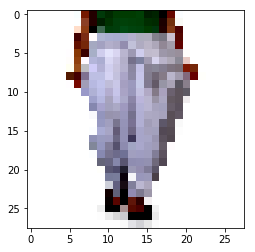

In [91]:
plt.imshow(images1[0])

In [92]:
images1[0].shape

(28, 28, 3)

In [93]:
# A convolutional autoencoder model
input_img = Input(shape=(28,28,3))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [94]:

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [95]:
#fitting the model for the images
autoencoder.fit(images1,images1,epochs=30,batch_size=64)

Epoch 1/30
3026/3026 [==============================] - 5s 2ms/step - loss: 0.3841
Epoch 2/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1963
Epoch 3/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1681
Epoch 4/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1554
Epoch 5/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1460
Epoch 6/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1400
Epoch 7/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1360
Epoch 8/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1331
Epoch 9/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1309
Epoch 10/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1291
Epoch 11/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1278
Epoch 12/30
3026/3026 [==============================] - 4s 1ms/step - loss: 0.1266
E

In [96]:
#extracting 128 features from each image
encode_images= encoder.predict(images1).reshape(3026,128)


In [98]:
#taking the product id from the images and splitting it and extracting only the productid
img_name=list(img_name)  
imgs_name_productid = []
for i in img_name:
  imgs_name_productid.append(int(i.split('.')[0]))

In [99]:
imgs_name_productid

[11139192,
 11139194,
 11139524,
 11139560,
 11139588,
 11139650,
 11141306,
 11141308,
 11141318,
 11141320,
 11141324,
 11141326,
 11141328,
 11141330,
 11141338,
 11141340,
 11141342,
 11141346,
 11141354,
 11141530,
 11141538,
 11141644,
 11144136,
 11144260,
 11145600,
 11145602,
 11145612,
 11145614,
 11145620,
 11145624,
 11145626,
 11145634,
 11145640,
 11145642,
 11145654,
 11145664,
 11145666,
 11145684,
 11145702,
 11145726,
 11145728,
 11145740,
 11145744,
 11145748,
 11145762,
 11146082,
 11146084,
 11146384,
 11146754,
 11147250,
 11147252,
 11147258,
 11147268,
 11147280,
 11147282,
 11147290,
 11147292,
 11147300,
 11147312,
 11147324,
 11147512,
 11147534,
 11147546,
 11147548,
 11147600,
 11147622,
 11148212,
 11148440,
 11148482,
 11148514,
 11148516,
 11148792,
 11148854,
 11148860,
 11148888,
 11148902,
 11148920,
 11148922,
 11148954,
 11148964,
 11148966,
 11148980,
 11148982,
 11148984,
 11149026,
 11149036,
 11149062,
 11149198,
 11149838,
 11149842,
 11149866,

In [100]:
#Creating a dataframe of image features
image_features_encoded = pd.DataFrame(encode_images,index=imgs_name_productid)
image_features_encoded.index.name='productid'
image_features_encoded

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
productid,,,,,,,,,,,,,,,,,,,,,
11139192,0.503517,0.694191,0.934531,1.048400,0.059863,1.039357,0.306488,0.386783,0.406224,0.626871,...,0.0,0.00000,1.108670,0.029223,0.981874,0.619772,0.0,0.000000,0.255464,0.000000
11139194,1.467322,0.464557,1.032300,0.954596,0.000000,0.825576,0.129142,0.374715,1.406255,0.601425,...,0.0,0.00000,1.085827,0.052206,0.962676,0.623958,0.0,0.000000,0.274831,0.000000
11139524,0.320537,0.591117,0.711844,1.199526,0.000379,1.009840,0.375692,0.297112,1.362140,0.580298,...,0.0,0.00000,1.094522,0.045159,0.959439,0.614894,0.0,0.000000,0.252583,0.000000
11139560,0.705237,0.581492,0.751353,1.202159,0.000000,1.006038,0.385495,0.247539,1.189765,0.783034,...,0.0,0.00000,1.088563,0.040915,0.957146,0.622182,0.0,0.000000,0.257428,0.000000
11139588,0.933522,0.589993,0.859123,1.005732,0.057489,0.961904,0.285080,0.452445,1.331843,0.611612,...,0.0,0.00000,1.014175,0.061354,0.812221,0.635072,0.0,0.000000,0.224344,0.000000
11139650,0.310550,0.583561,0.719332,1.198941,0.000000,1.007775,0.375911,0.345672,1.343154,0.598372,...,0.0,0.00000,1.087995,0.056468,0.941908,0.634082,0.0,0.000000,0.250077,0.000000
11141306,1.424182,0.610184,0.896075,0.965588,0.000000,0.992076,0.122875,0.366903,1.437973,0.591476,...,0.0,0.00000,1.085940,0.055392,0.957566,0.632242,0.0,0.000000,0.273473,0.000000
11141308,1.298782,0.714494,0.871037,0.967993,0.000000,0.980731,0.182443,0.505826,1.100795,0.782133,...,0.0,0.00000,1.074159,0.055690,0.930103,0.631005,0.0,0.000000,0.261627,0.000000
11141318,0.897566,1.071746,0.894184,0.695117,0.411563,0.869341,0.064409,0.690329,0.680154,0.895405,...,0.0,0.00000,1.093071,0.044642,0.969690,0.621522,0.0,0.000000,0.269106,0.000000


In [101]:
#list of products that are not present in the product attribute dataset
set(imgs_name_productid) - set(product['productid'].unique())

{12947666,
 12995896,
 13017336,
 13072176,
 13072610,
 13653544,
 13773574,
 14101712,
 14122346,
 14122348,
 14129477}

In [102]:
#checking for each atribute name how many attribute values fall under each of them
product[['attribute_name', 'attributevalue']].groupby(['attribute_name'])['attributevalue'].nunique()

attribute_name
Category           5
Collection        21
Color            131
Fabric            33
Fit                6
Material           4
Neckline          12
Season             8
Sleeve Length     15
Name: attributevalue, dtype: int64

In [103]:
#Changing the attribute to category so that it is easy to create dummies for our dataframe
product['attributevalue'] = product['attributevalue'].astype('category')

In [104]:
#one hot encode where it concat the products attribute and the dummies for every attribute value
pro_df = pd.concat([product, pd.get_dummies(product[['attribute_name', 'attributevalue']])], axis=1).drop(['attribute_name', 'attributevalue'], axis=1)

In [105]:
pro_df = pro_df.groupby(['productid']).sum()
(pro_df > 1).sum()

attribute_name_Category         0
attribute_name_Collection       0
attribute_name_Color            2
attribute_name_Fabric           2
attribute_name_Fit              1
attribute_name_Material         0
attribute_name_Neckline         2
attribute_name_Season           0
attribute_name_Sleeve Length    0
attributevalue_0                0
attributevalue_1                0
attributevalue_2                0
attributevalue_3                0
attributevalue_4                0
attributevalue_5                0
attributevalue_6                0
attributevalue_7                0
attributevalue_8                0
attributevalue_9                0
attributevalue_10               0
attributevalue_11               0
attributevalue_12               0
attributevalue_13               0
attributevalue_14               0
attributevalue_15               0
attributevalue_16               0
attributevalue_17               0
attributevalue_18               0
attributevalue_19               0
attributevalue

In [106]:
#clipp upper is used to trim values based on the limit given inside the paranthesis
pro_df.clip_upper(1)

,attribute_name_Category,attribute_name_Collection,attribute_name_Color,attribute_name_Fabric,attribute_name_Fit,attribute_name_Material,attribute_name_Neckline,attribute_name_Season,attribute_name_Sleeve Length,attributevalue_0,...,attributevalue_224,attributevalue_225,attributevalue_226,attributevalue_227,attributevalue_228,attributevalue_229,attributevalue_230,attributevalue_231,attributevalue_232,attributevalue_233
productid,,,,,,,,,,,,,,,,,,,,,
11139192,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11139194,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11139524,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11139560,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11139588,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11139650,1,0,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
11141306,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11141308,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
11141318,1,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
#gives index to the dataframe
pro_df.reset_index(inplace=True)

In [108]:
#merging all the features based on the product attribute dataset and as well as from images
prod_feats_df = image_features_encoded.merge(pro_df,on='productid',how='left')

In [109]:
prod_feats_df

,productid,0,1,2,3,4,5,6,7,8,...,attributevalue_224,attributevalue_225,attributevalue_226,attributevalue_227,attributevalue_228,attributevalue_229,attributevalue_230,attributevalue_231,attributevalue_232,attributevalue_233
0,11139192,0.503517,0.694191,0.934531,1.048400,0.059863,1.039357,0.306488,0.386783,0.406224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11139194,1.467322,0.464557,1.032300,0.954596,0.000000,0.825576,0.129142,0.374715,1.406255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11139524,0.320537,0.591117,0.711844,1.199526,0.000379,1.009840,0.375692,0.297112,1.362140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11139560,0.705237,0.581492,0.751353,1.202159,0.000000,1.006038,0.385495,0.247539,1.189765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11139588,0.933522,0.589993,0.859123,1.005732,0.057489,0.961904,0.285080,0.452445,1.331843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,11139650,0.310550,0.583561,0.719332,1.198941,0.000000,1.007775,0.375911,0.345672,1.343154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11141306,1.424182,0.610184,0.896075,0.965588,0.000000,0.992076,0.122875,0.366903,1.437973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,11141308,1.298782,0.714494,0.871037,0.967993,0.000000,0.980731,0.182443,0.505826,1.100795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,11141318,0.897566,1.071746,0.894184,0.695117,0.411563,0.869341,0.064409,0.690329,0.680154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11141320,0.893333,0.742535,1.013903,0.909293,0.000000,1.022186,0.227704,0.273622,1.156059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
prod_feats_df.fillna(0,inplace=True)

In [111]:
prod_feats_df.drop(['productid'],axis=1,inplace=True)

In [112]:
#creating a dataframe on user id and the weightage given by him for each product feature
user_prof_df = pd.DataFrame(index=sorted(test_df['UserId'].unique()), columns=prod_feats_df.columns.values)

In [113]:
user_prof_df

,0,1,2,3,4,5,6,7,8,9,...,attributevalue_224,attributevalue_225,attributevalue_226,attributevalue_227,attributevalue_228,attributevalue_229,attributevalue_230,attributevalue_231,attributevalue_232,attributevalue_233
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
n_users = train_df['UserId'].nunique()
n_products = train_df['productid'].nunique()

In [115]:

data_matrix_df = pd.DataFrame(np.zeros((n_users, n_products)), index=sorted(train_df['UserId'].unique()), columns=sorted(train_df['productid'].unique()))

In [117]:
%%time
for i, line in train_df.iterrows():
    data_matrix_df.loc[line['UserId'], line['productid']] = data_matrix_df.loc[line['UserId'], line['productid']] + line['Quantity']

Wall time: 43.2 s


In [118]:
len(prod_feats_df.values)

3026

In [119]:
#weighted sum of product features
#Calcuating the weights of each products for the particular user
for user in sorted(test_df['UserId'].unique()):
    user_prof_df.loc[user] = ((prod_feats_df.values  * data_matrix_df.loc[user].values.reshape(3026,1)).sum(axis=0)) / data_matrix_df.loc[user].sum()

In [120]:
user_prof_df.head()

,0,1,2,3,4,5,6,7,8,9,...,attributevalue_224,attributevalue_225,attributevalue_226,attributevalue_227,attributevalue_228,attributevalue_229,attributevalue_230,attributevalue_231,attributevalue_232,attributevalue_233
2,0.258395,0.588582,0.733774,1.20438,0.00906127,1.00265,0.381627,0.273509,1.22429,0.875037,...,0,0,0,0,0,0,0,0,0,0
28,0.552376,0.581036,0.734615,1.2176,0.00792214,0.967256,0.382536,0.324747,1.30218,0.616431,...,0,0,0,0,0,0,0,0,0,0
36,0.713707,0.553864,0.698732,1.22131,0,1.02103,0.364705,0.348336,1.77889,0.52147,...,0,0,0,0,0,0,0,0,0,0
38,0.644176,0.563026,0.70899,1.21204,0,1.00791,0.365847,0.341657,1.50285,0.650584,...,0,0,0,0,0,0,0,0,0,0
41,0.60135,0.55176,0.745901,1.19469,0,0.985715,0.373636,0.321536,1.61332,0.510583,...,0,0,0,0,0,0,0,0,0,0


In [121]:
#Computing similarity for user and product
user_prof_prods_similarity = pairwise_distances(user_prof_df, prod_feats_df, metric='cosine')

In [122]:
# 1 denotes higher similarity
user_prof_prods_similarity_df = 1 - pd.DataFrame(user_prof_prods_similarity, index=user_prof_df.index.values, columns=imgs_name_productid)

In [123]:
user_prof_prods_similarity_df.head()

,11139192,11139194,11139524,11139560,11139588,11139650,11141306,11141308,11141318,11141320,...,14122758,14122762,14122766,14122818,14122820,14122822,14122832,14122834,14128359,14129477
2,0.838512,0.774948,0.911675,0.899827,0.810912,0.915502,0.791350,0.808831,0.781826,0.797053,...,0.856482,0.861890,0.854974,0.863070,0.823569,0.854210,0.852885,0.861343,0.688049,0.855954
28,0.882146,0.836019,0.909995,0.913293,0.865191,0.916145,0.841196,0.867330,0.829283,0.850286,...,0.926930,0.929094,0.913322,0.927290,0.891095,0.913553,0.937414,0.934598,0.734927,0.877855
36,0.859036,0.893977,0.889481,0.881909,0.894595,0.895203,0.886783,0.883718,0.850357,0.880984,...,0.917078,0.913204,0.917769,0.901514,0.908383,0.889434,0.929399,0.911093,0.694893,0.845675
38,0.898299,0.882167,0.918214,0.928387,0.892808,0.932044,0.880575,0.897889,0.864552,0.887560,...,0.936059,0.935308,0.932547,0.916426,0.891937,0.914662,0.931320,0.939600,0.719335,0.875726
41,0.888099,0.884063,0.907779,0.915777,0.883318,0.925713,0.874844,0.891692,0.856137,0.884060,...,0.934351,0.931941,0.926508,0.889445,0.856439,0.875674,0.912545,0.936064,0.695320,0.842061


In [124]:
#predicting values for the testdata
content_pred_sub = pd.DataFrame(columns=['UserId', 'product_list'])
content_pred_sub['UserId'] = test_df['UserId'].values

In [125]:
#predicting vales for the productlist
sub_list = []
for user in content_pred_sub['UserId'].values:
    sub_list.append(user_prof_prods_similarity_df.loc[user].sort_values(ascending=False)[0:10].index.values.tolist())

In [126]:
#predicted values
content_pred_sub['product_list'] = sub_list
content_pred_sub.head()

,UserId,product_list
0,2,"[11660064, 11660226, 12657952, 13653526, 11660..."
1,28,"[11714534, 13039812, 12407652, 13064990, 13039..."
2,36,"[12360448, 12407802, 12360460, 11360728, 12407..."
3,38,"[11659798, 12371386, 11659238, 12407708, 12406..."
4,41,"[11659236, 11659232, 11659238, 11659246, 11659..."
